# Workflow for processing  Litchfield 29JUN18

In [1]:
import time
start_time = time.time()
import os, shutil, sys
sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib

#
# Astropy is used to determine the Solar angle
#
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u

import datacube

from CalVal import *

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['savefig.dpi'] = 300

In [2]:
import numpy as np

#
# Set up input and output directories
#
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/testing/'
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/LIT-MultiTimeLine/'

#
# field_data is in the format: 'Field Site Name', 'Date', 'Site number', 'Satellite Name'
# NOTE: Satellite name should be one of: 'Landsat8', 'Sentinel2a', or 'Sentinel2b'.
#
field_data = ['LIT', '29JUN18', '', 'Sentinel2a']

#
# timerange gives the dates which include the relevant satellite overpass.
#
timerange = ('2018-06-27', '2018-07-02')

#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
#bad_grounds = ['llg_l300010.asd.rad', 'llg_l300011.asd.rad', 'llg_l300038.asd.rad', 'llg_l300039.asd.rad', 'llg_l300040.asd.rad', 'llg_l300041.asd.rad']
bad_grounds = []
#bad_pans = ['lkg_l700000.asd.rad', 'lkg_l700001.asd.rad']
bad_pans = []

ls8_bad_days = ['2013-03-23', '2013-05-21', '2013-06-06', '2013-06-22', '2013-07-08',
                '2013-09-10', '2013-12-15', '2013-12-31', '2014-01-16', '2014-02-17',
                '2014-03-05', '2014-03-21', '2014-04-06', '2014-10-15', '2014-11-16',
                '2014-12-18', '2015-01-03', '2015-01-19', '2015-02-04', '2015-02-20',
                '2015-03-08', '2015-03-24', '2015-05-27', '2015-08-31', '2015-09-16',
                '2015-10-18', '2015-11-03', '2015-11-19', '2015-12-05', '2015-12-21',
                '2016-01-06', '2016-01-22', '2016-02-07', '2016-02-23', '2016-03-10',
                '2016-03-26', '2016-04-27', '2016-05-29', '2016-09-02', '2016-09-18',
                '2016-10-04', '2016-10-20', '2016-11-05', '2016-11-21', '2016-12-07',
                '2016-12-23', '2017-01-08', '2017-01-24', '2017-02-09', '2017-02-25',
                '2017-03-13', '2017-03-29', '2017-04-14', '2017-05-16', '2017-06-01',
                '2017-10-07', '2017-11-08', '2017-11-24', '2017-12-26', '2018-01-27',
                '2018-02-12', '2018-02-28', '2018-04-01', '2018-05-03', '2018-09-08',
                '2018-09-24', '2018-10-26', '2018-11-11']
s2a_bad_days = ['2015-09-13', '2015-10-23', '2015-12-22', '2016-01-01', '2016-01-21',
                '2016-01-31', '2016-02-10', '2016-03-11', '2016-04-20', '2016-04-30',
                '2016-05-10', '2016-05-30', '2016-06-09', '2016-08-08', '2016-09-07',
                '2016-09-27', '2016-10-27', '2016-11-06', '2016-11-16', '2016-11-26',
                '2016-12-06', '2016-12-16', '2016-12-26', '2017-01-05', '2017-01-15',
                '2017-01-25', '2017-02-04', '2017-02-14', '2017-02-24', '2017-03-06',
                '2017-03-16', '2017-03-26', '2017-04-15', '2017-06-04', '2017-10-02',
                '2017-10-22', '2017-11-01', '2017-11-11', '2017-11-21', '2017-12-01',
                '2017-12-11', '2017-12-31', '2018-01-20', '2018-02-09', '2018-02-19',
                '2018-03-11', '2018-03-21', '2018-03-31', '2018-04-10', '2018-06-19']
s2b_bad_days = ['2017-07-09', '2017-07-29', '2017-08-18', '2017-09-27', '2017-10-07',
                '2017-10-17', '2017-10-27', '2017-11-06', '2017-11-16', '2017-12-16',
                '2017-12-26', '2018-01-05', '2018-01-15', '2018-01-25', '2018-02-14',
                '2018-02-24', '2018-03-16', '2018-03-26', '2018-04-05', '2018-05-15',
                '2018-06-14']
                
ls8_csvs = ['LIT_29JUN18__Landsat8.csv']

sent_csvs = ['LIT_29JUN18__Sentinel2a.csv']

rain_dat = '../Weather/IDCJAC0009_014279_1800_Data.csv'

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 2

#
# Calculated BRDF data
#
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.041688, 0.007344, 0.010268000000000001],
                          ['band11', 0.261668, 0.037712, 0.049928],
                          ['band12', 0.143828, 0.0023320000000000003, 0.03777200000000001],
                          ['band2', 0.041688, 0.007344, 0.010268000000000001],
                          ['band3', 0.071384, 0.03126, 0.015428],
                          ['band4', 0.09034, 0.011872, 0.0239],
                          ['band5', 0.09034, 0.011872, 0.0239],
                          ['band6', 0.09034, 0.011872, 0.0239],
                          ['band7', 0.234656, 0.204964, 0.008268000000000001],
                          ['band8', 0.234656, 0.204964, 0.008268000000000001],
                          ['band8a', 0.234656, 0.204964, 0.008268000000000001],
                         ])
#
# plot_scale defines the extent of the axes in the final two plots in the workflow.
# A scale from 0-1 means no reflectance to perfect reflectance. Typically, dark sites
# will range from 0-0.3, whereas bright sites will be between 0-1.
#
plot_scale = [0.0, 0.3, 0.0, 0.3]

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = False

In [3]:
#######################################
# LINES BELOW SHOULD REMAIN UNCHANGED #
#######################################

#
# Remove old files in directory and create a new one
#
directory = os.path.dirname(output)
if os.path.exists(directory):
    shutil.rmtree(directory)
os.makedirs(directory)


#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
suffix = 'asd.rad.txt'
panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
in_panel = 'ga_panel1_jan_2018.txt'

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Start Figure numbering at 1
#
fignum = 1


In [4]:
import pandas as pd
#drone = pd.read_csv('/g/data/u46/users/aw3463/GuyByrne/30APR18/litchfield/target-20180629_013116.csv')
drone = pd.read_csv('/g/data/u46/users/aw3463/GuyByrne/30APR18/litchfield/cutends.csv')

In [5]:
pd.options.display.max_rows = 200
drone

timestamp   latitude   longitude  altitude  relaltitude  \
0     2018-06-29T01:31:48.86Z -13.181483  130.788650    276.02        49.83   
1     2018-06-29T01:31:49.06Z -13.181470  130.788650    276.01        49.82   
2     2018-06-29T01:31:49.25Z -13.181457  130.788649    276.01        49.82   
3     2018-06-29T01:31:49.45Z -13.181450  130.788649    276.01        49.82   
4     2018-06-29T01:31:49.65Z -13.181437  130.788649    276.01        49.82   
5     2018-06-29T01:31:49.85Z -13.181420  130.788648    275.99        49.80   
6     2018-06-29T01:31:50.08Z -13.181401  130.788648    275.97        49.78   
7     2018-06-29T01:31:50.28Z -13.181386  130.788648    275.96        49.77   
8     2018-06-29T01:31:50.46Z -13.181371  130.788647    275.96        49.77   
9     2018-06-29T01:31:50.66Z -13.181355  130.788647    275.96        49.77   
10    2018-06-29T01:31:50.89Z -13.181336  130.788647    275.99        49.80   
11    2018-06-29T01:31:51.11Z -13.181318  130.788647    276.00        49.81   
12    2018-06-29T01:31:51.30Z -13.181302  130.788647    276.02        49.83   
13    2018-06-29T01:31:51.49Z -13.181287  130.788647    276.06        49.87   
14    2018-06-29T01:31:51.68Z -13.181271  130.788647    276.09        49.90   
15    2018-06-29T01:31:51.90Z -13.181258  130.788647    276.11        49.92   
16    2018-06-29T01:31:52.09Z -13.181245  130.788647    276.15        49.96   
17    2018-06-29T01:31:52.28Z -13.181229  130.788647    276.18        49.99   
18    2018-06-29T01:31:52.47Z -13.181213  130.788647    276.21        50.02   
19    2018-06-29T01:31:52.66Z -13.181197  130.788647    276.21        50.02   
20    2018-06-29T01:31:52.88Z -13.181179  130.788647    276.21        50.02   
21    2018-06-29T01:31:53.07Z -13.181162  130.788647    276.23        50.04   
22    2018-06-29T01:31:53.26Z -13.181147  130.788647    276.24        50.05   
23    2018-06-29T01:31:53.48Z -13.181127  130.788647    276.26        50.07   
24    2018-06-29T01:31:53.67Z -13.181111  130.788647    276.29        50.10   
25    2018-06-29T01:31:53.87Z -13.181093  130.788646    276.32        50.13   
26    2018-06-29T01:31:54.07Z -13.181077  130.788646    276.31        50.12   
27    2018-06-29T01:31:54.26Z -13.181061  130.788646    276.30        50.11   
28    2018-06-29T01:31:54.47Z -13.181049  130.788645    276.28        50.09   
29    2018-06-29T01:31:54.68Z -13.181031  130.788645    276.25        50.06   
30    2018-06-29T01:31:54.89Z -13.181013  130.788645    276.24        50.05   
31    2018-06-29T01:31:55.09Z -13.180995  130.788644    276.22        50.03   
32    2018-06-29T01:31:55.29Z -13.180978  130.788644    276.21        50.02   
33    2018-06-29T01:31:55.48Z -13.180960  130.788643    276.20        50.01   
34    2018-06-29T01:31:55.67Z -13.180944  130.788643    276.20        50.01   
35    2018-06-29T01:31:55.88Z -13.180924  130.788643    276.22        50.03   
36    2018-06-29T01:31:56.08Z -13.180906  130.788642    276.23        50.04   
37    2018-06-29T01:31:56.30Z -13.180887  130.788642    276.23        50.04   
38    2018-06-29T01:31:56.50Z -13.180869  130.788642    276.22        50.03   
39    2018-06-29T01:31:56.70Z -13.180851  130.788642    276.23        50.04   
40    2018-06-29T01:31:56.93Z -13.180836  130.788642    276.23        50.04   
41    2018-06-29T01:31:57.14Z -13.180820  130.788642    276.24        50.05   
42    2018-06-29T01:31:57.33Z -13.180804  130.788642    276.24        50.05   
43    2018-06-29T01:31:57.52Z -13.180786  130.788642    276.21        50.02   
44    2018-06-29T01:31:57.72Z -13.180768  130.788642    276.20        50.01   
45    2018-06-29T01:31:57.94Z -13.180747  130.788643    276.19        50.00   
46    2018-06-29T01:31:58.15Z -13.180729  130.788643    276.17        49.98   
47    2018-06-29T01:31:58.34Z -13.180711  130.788643    276.17        49.98   
48    2018-06-29T01:31:58.53Z -13.180694  130.788643    276.18        49.99   
49    2018-06-29T01:31:58.72Z -13.180676  130.788643    276.18        

In [6]:
dronent = drone.drop(['timestamp', 'latitude', 'longitude', 'altitude', 'relaltitude', 'roll', 'pitch', 'yaw'], axis=1)

In [7]:
dronet = dronent.T

In [8]:
#for i in range(350, 822):
#    print(i)
dronet.index.name ='Wavelength'

In [9]:
dee = dronet.copy()
dee = dee[dee.index.astype(float) >1000]

In [10]:
for i in range(350, 822):
    dee.loc[i] = dronet[(i-1 < dronet.index.astype(float)) & (dronet.index.astype(float) < i+1)].mean()
for i in range(822, 2501):
    dee.loc[i] = dronet[821]

In [11]:
f_name = sat_resp['Landsat8']
result_ls8_df, dummy, band_ls8, dummy2 = ApplyWeights.apply_weights(f_name, dee, sat_resp, field_data)
f_name = sat_resp['Sentinel2a']
dummy, result_s2a_df, dummy2, band_s2a = ApplyWeights.apply_weights(f_name, dee, sat_resp, field_data)
f_name = sat_resp['Sentinel2b']
dummy, result_s2b_df, dummy2, band_s2b = ApplyWeights.apply_weights(f_name, dee, sat_resp, field_data)


In [12]:
catty_ls8 = pd.concat([drone[['timestamp', 'latitude', 'longitude', 'roll', 'pitch']],result_ls8_df], axis=1)
catty_s2a = pd.concat([drone[['timestamp', 'latitude', 'longitude', 'roll', 'pitch']],result_s2a_df], axis=1)
catty_s2b = pd.concat([drone[['timestamp', 'latitude', 'longitude', 'roll', 'pitch']],result_s2b_df], axis=1)

In [13]:
catty_ls8.rename(columns={'timestamp': 'date_saved', 'latitude': 'Latitude', 'longitude': 'Longitude', 'roll': 'Line', 'pitch': 'Spec_number'}, inplace=True)
catty_s2a.rename(columns={'timestamp': 'date_saved', 'latitude': 'Latitude', 'longitude': 'Longitude', 'roll': 'Line', 'pitch': 'Spec_number'}, inplace=True)
catty_s2b.rename(columns={'timestamp': 'date_saved', 'latitude': 'Latitude', 'longitude': 'Longitude', 'roll': 'Line', 'pitch': 'Spec_number'}, inplace=True)

In [14]:
catty_ls8['Line'] = 1
catty_ls8['Spec_number'] = 1
catty_s2a['Line'] = 1
catty_s2a['Spec_number'] = 1
catty_s2b['Line'] = 1
catty_s2b['Spec_number'] = 1

# Figure 

### Plot band reflectances

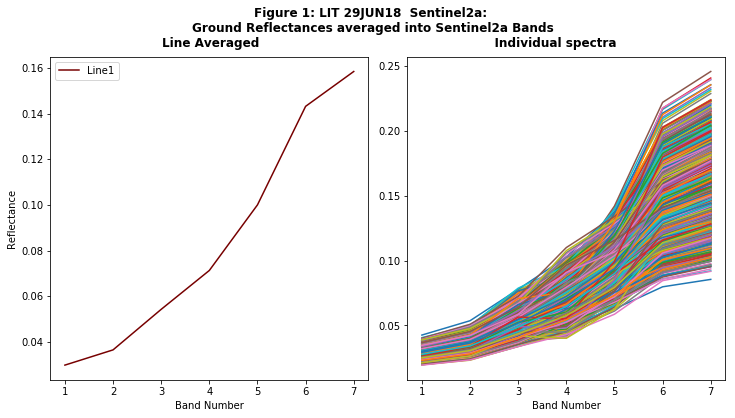

In [15]:
FIG_BandReflectances.FIG_band_reflectances(catty_ls8, result_ls8_df, band_ls8, catty_s2a, result_s2a_df, band_s2a, colpac, output, field_data, fignum)
fignum += 1
#FIG_BandReflectances.FIG_band_reflectances(catty_ls8, result_ls8_df, band_ls8, colpac, output, field_data, fignum)
#fignum += 1
#FIG_BandReflectances.FIG_band_reflectances(catty_s2a, result_s2a_df, band_s2a, colpac, output, field_data, fignum)
#fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

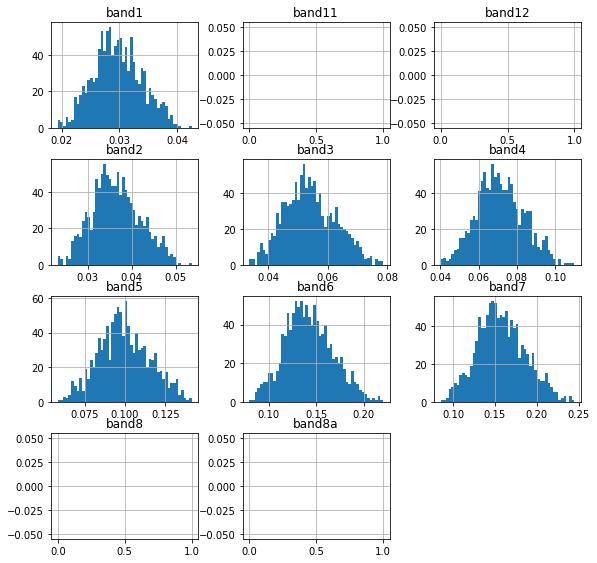

In [16]:
FIG_SpecHistogram.FIG_spec_histogram(catty_ls8, catty_s2b, output, field_data, fignum)
fignum += 1

### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [17]:
def solar_angle(row):

    loc = coord.EarthLocation(lon=row['Longitude'] * u.deg,
                              lat=row['Latitude'] * u.deg)
    #timy0 = timei.to_pydatetime()
    timy = Time(row['date_saved'])#, format='datetime')
    
    altaz = coord.AltAz(location=loc, obstime=timy)
    sun = coord.get_sun(timy)

    return sun.transform_to(altaz).zen.degree

catty_ls8['Solar_angle'] = catty_ls8.apply(solar_angle, axis=1)
catty_s2a['Solar_angle'] = catty_s2a.apply(solar_angle, axis=1)
catty_s2b['Solar_angle'] = catty_s2b.apply(solar_angle, axis=1)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [18]:
ground_brdf_ls8, dummy, hb, br = BRDF.ReadAndCalc(brdf_data, catty_ls8, catty_s2a, ['','','','Landsat8'])
dummy, ground_brdf_s2a, hb, br = BRDF.ReadAndCalc(brdf_data, catty_ls8, catty_s2a, ['','','','Sentinel2a'])
dummy, ground_brdf_s2b, hb, br = BRDF.ReadAndCalc(brdf_data, catty_ls8, catty_s2b, ['','','','Sentinel2b'])


### Choose bands for Landsat 8 and Sentinel satellite data

In [19]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

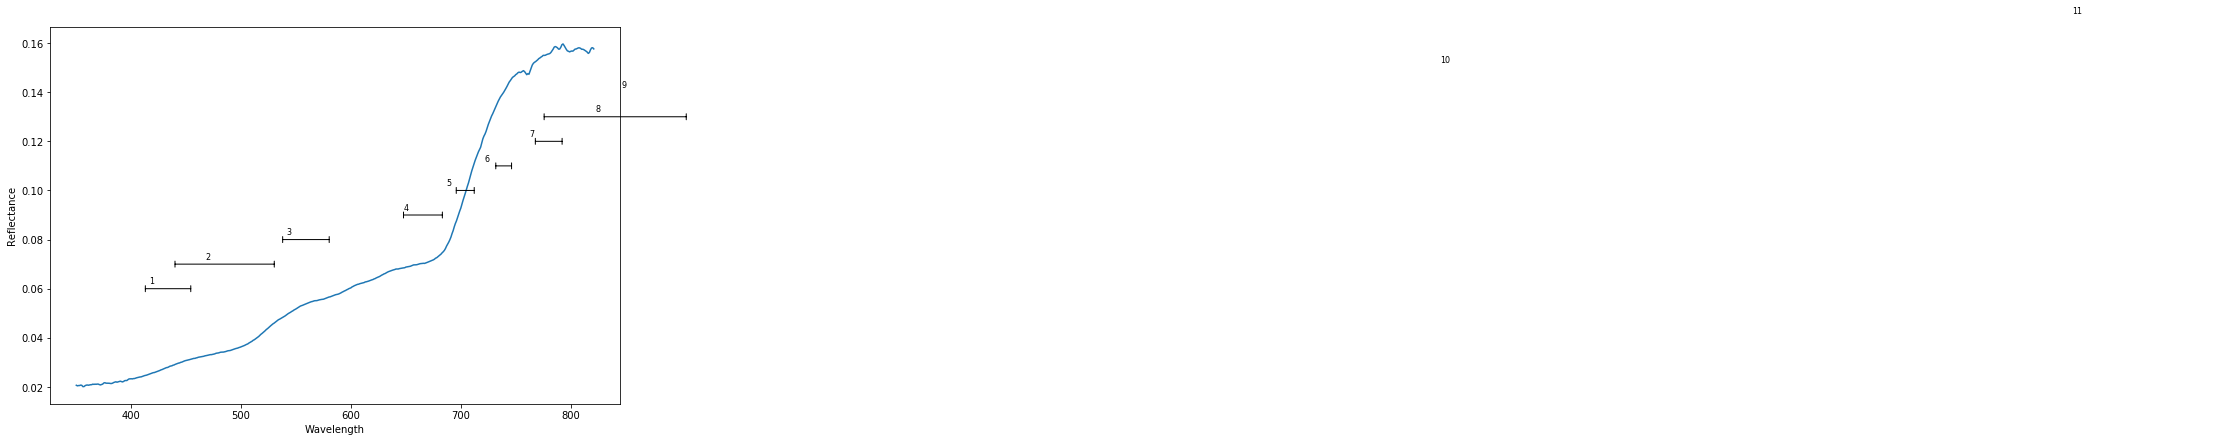

In [20]:
FIG_BandExtents.FIG_band_extents(dee, band_min, band_max, output, field_data, fignum)
fignum += 1

### Fudge GPS locations if none exist

In [21]:
StartCorner = 'SE'

ground_brdf_ls8 = FudgeGPS.fudge_gps(ground_brdf_ls8, Corners, RockWalk, StartCorner)
ground_brdf_s2a = FudgeGPS.fudge_gps(ground_brdf_s2a, Corners, RockWalk, StartCorner)
ground_brdf_s2b = FudgeGPS.fudge_gps(ground_brdf_s2b, Corners, RockWalk, StartCorner)

Assuming good GPS Coordinates, continuing...
Assuming good GPS Coordinates, continuing...
Assuming good GPS Coordinates, continuing...


### Print out time stamp and coordinate extent for BRDF correction

The time stamp and Lat/Long extents are required to calculate the BRDF correction, used below.

In order to calculate the BRF correction, the following method is used:

<OL>
    <LI>Run the print statements in the cell below.</LI>
    <LI>Copy and paste the output into a VDI terminal window</LI>
    <LI>Copy and paste the resultant VDI output into the BRDF calculation cell, writing over the similar text.</LI>
</OL>

NOTE: This works assuming that the BRDF code is in the current directory.


In [22]:
PrintBRDF.print_brdf(catty_s2a, field_data)

#################################################################################
# Copy and paste the following into a terminal window on VDI for Landsat 8 data #
#################################################################################

source module.sh
sed -i "34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('2018-06-29T01:31:48.86Z'))/" retrieve_brdf.py
sed -i "37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(130.78864199999998, -13.181482999999998, 130.790043, -13.180303)]})/" retrieve_brdf.py
python retrieve_brdf.py > temp.txt ; awk -f format_Sent.awk temp.txt



### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.

In [23]:
ldc, sdc, lquery, squery, lquery2, squery2 = LongQuery.make_long_query(ground_brdf_ls8)

ls8_array, s2a_array, s2b_array, ls8_bigarray, s2a_bigarray, s2b_bigarray = CreateLongArrays.create_long_arrays_nomask(ldc, sdc, lquery, squery, lquery2, squery2)

# Figure 

### Plot relative locations of field and satellite data

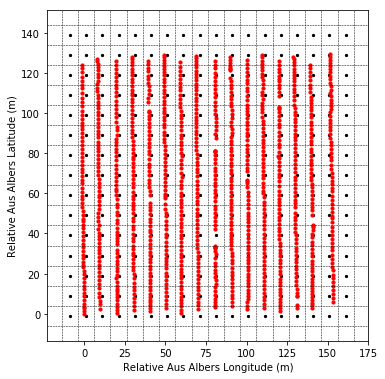

In [24]:
#xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ground_brdf_s2a, s2a_array, colpac, output, field_data, fignum)
#fignum +=1

xloc, sxloc = FIG_SatFieldLocations.FIG_sat_field_locations(ground_brdf_ls8, ground_brdf_s2a, ls8_array, s2a_array, colpac, output, field_data, fignum)
fignum +=1

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [25]:
field_array_ls8, field_array_s2a = CreateManyFieldFromSat.create_many_field_from_sat(ls8_array, s2a_array, ground_brdf_ls8, ground_brdf_s2a, xloc)

# Figure 

### Plot large-area context RGB array for Satellite data

Landsat 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

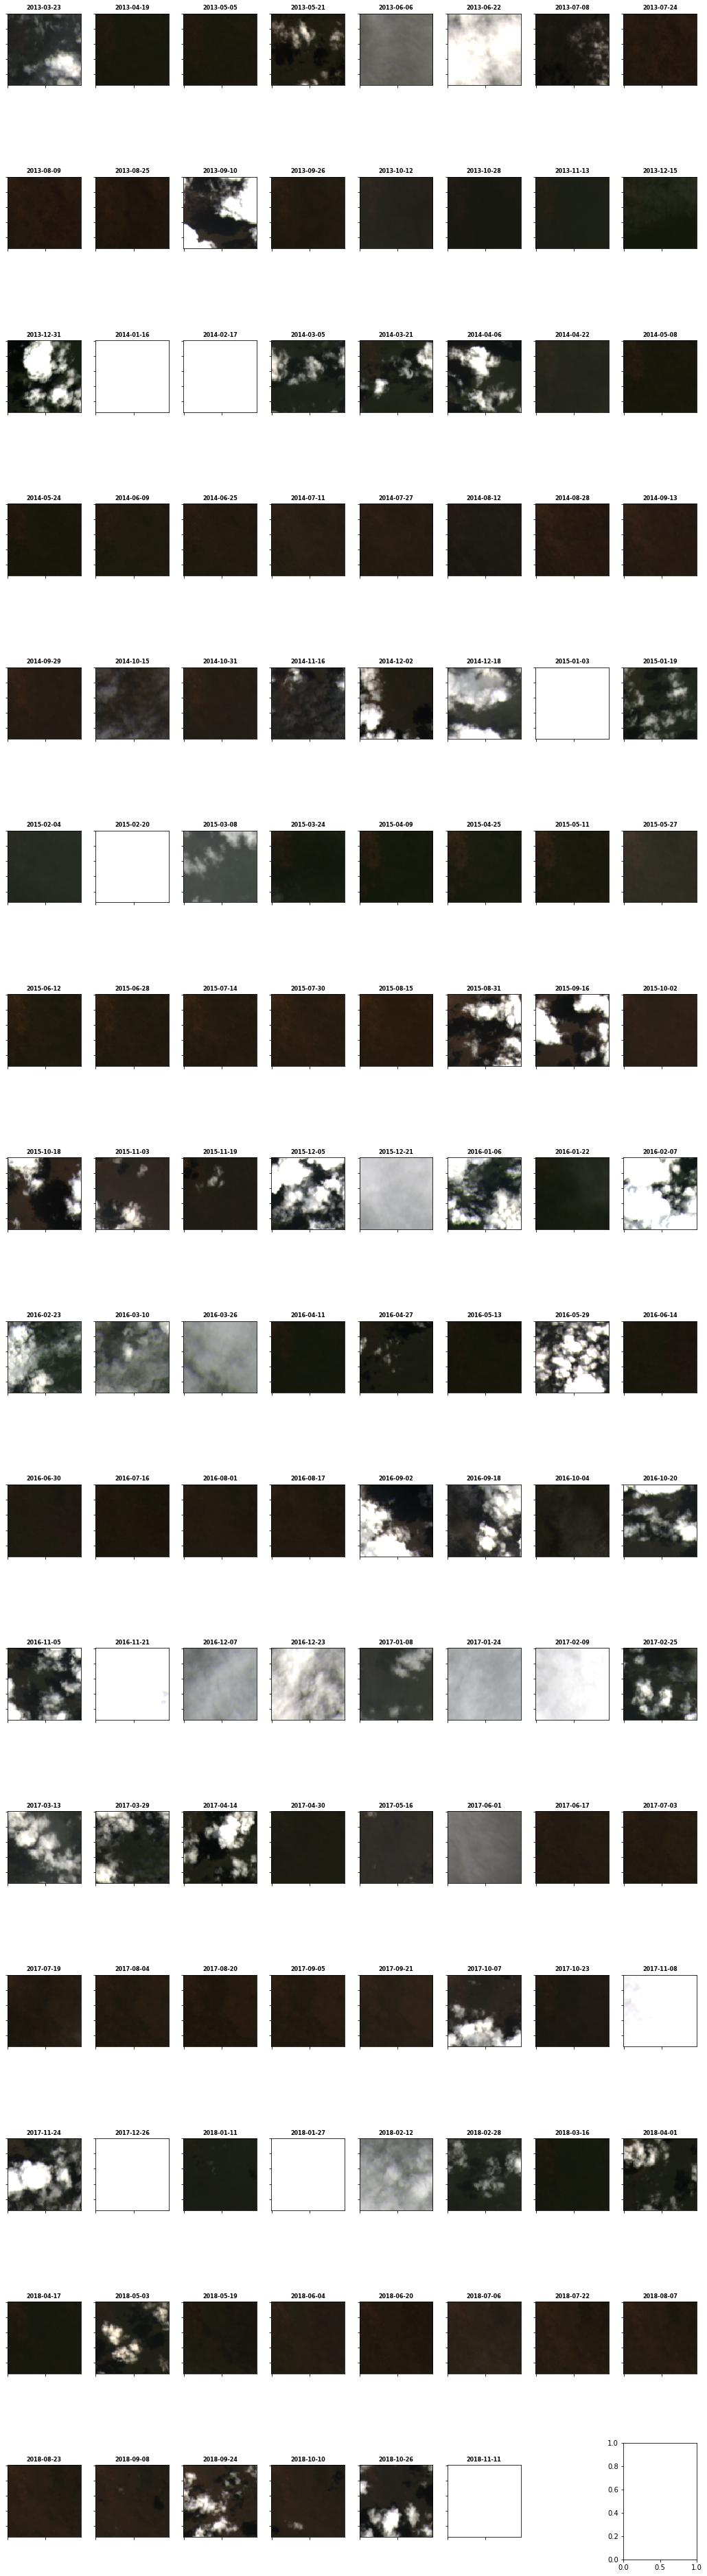

In [26]:
FIG_ManyLS8RGB.FIG_many_LS8RGB(ls8_bigarray, output, field_data, fignum)
fignum += 1

Sentinel 2a


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

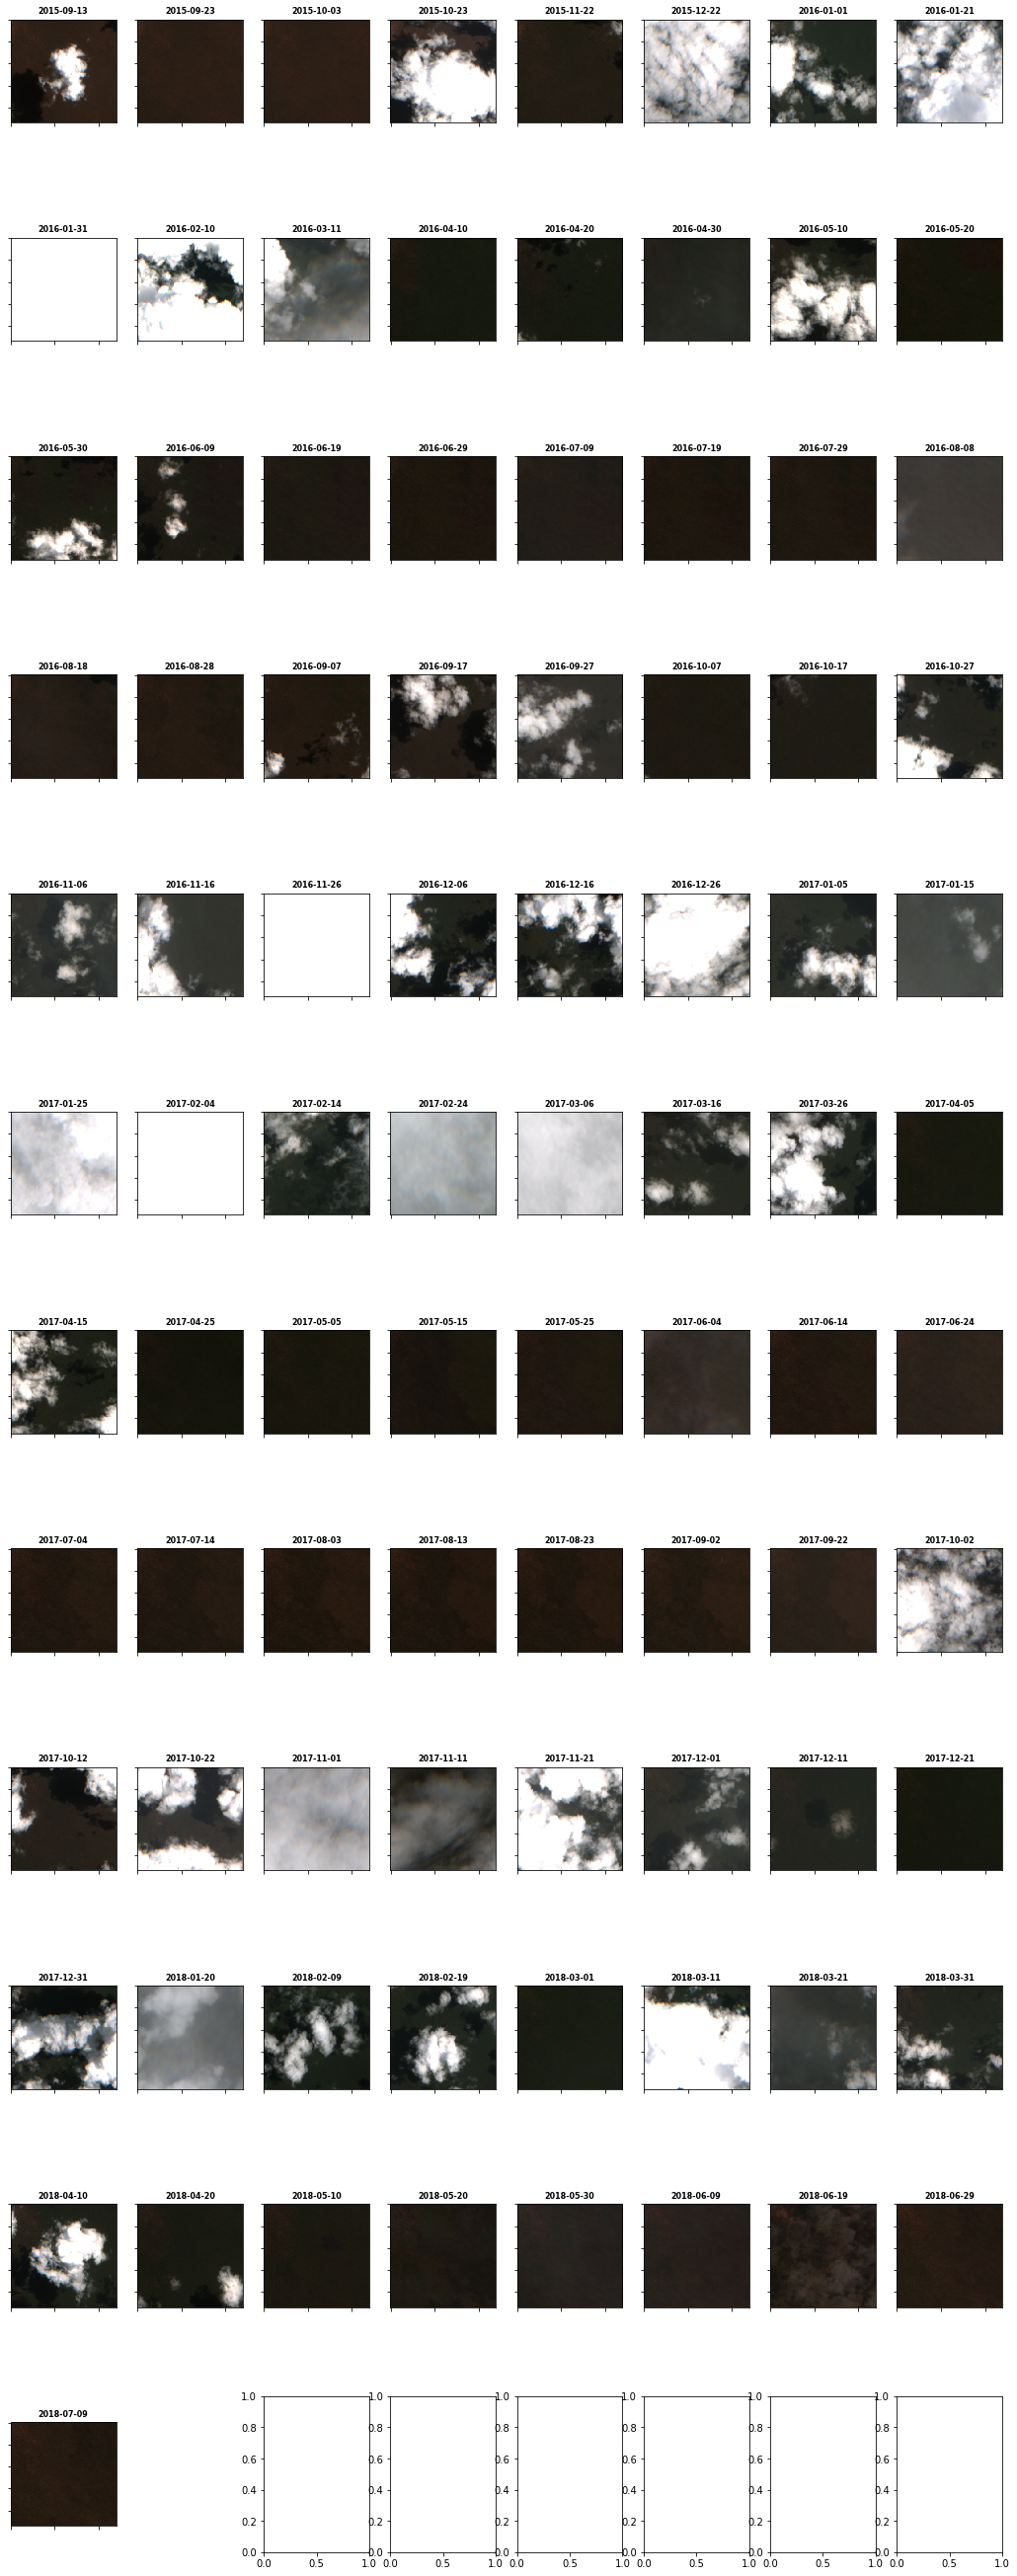

In [27]:
FIG_ManyS2ARGB.FIG_many_S2ARGB(s2a_bigarray, output, field_data, fignum)
fignum += 1

Sentinel 2b


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

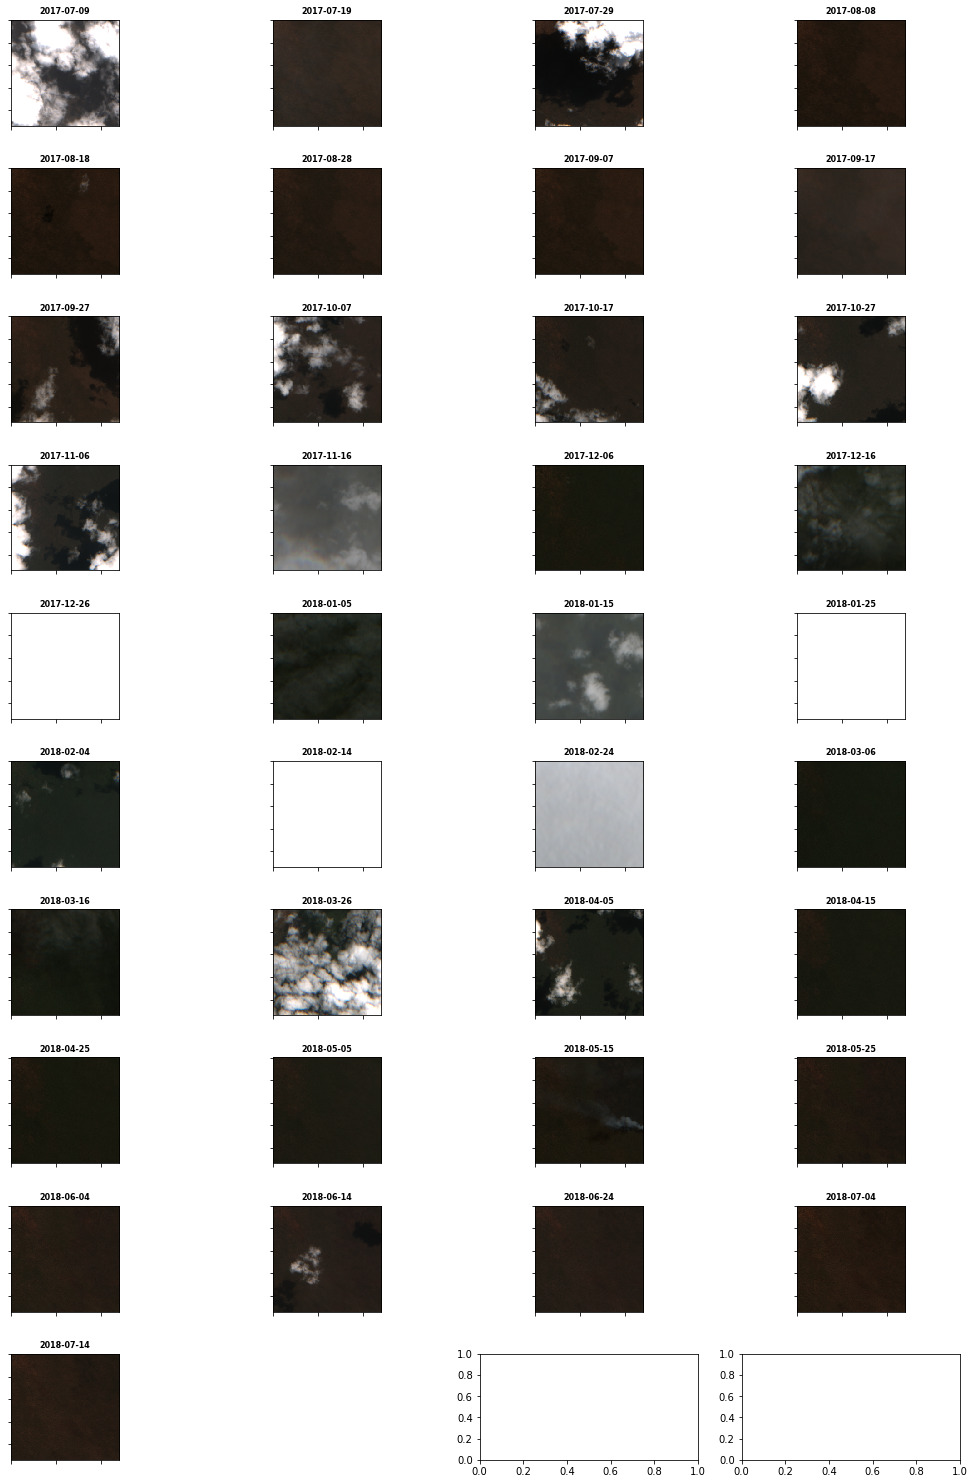

In [28]:
FIG_ManyS2BRGB.FIG_many_S2BRGB(s2b_bigarray, output, field_data, fignum)
fignum += 1

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


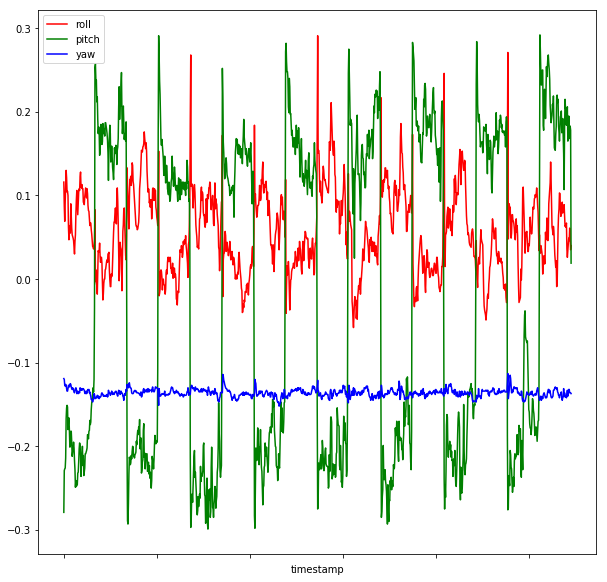

In [29]:
drone.plot('timestamp', ['roll', 'pitch', 'yaw'], figsize=(10,10), colors=['red','green','blue'])

# Figure 

### Plot RGB array for Field data

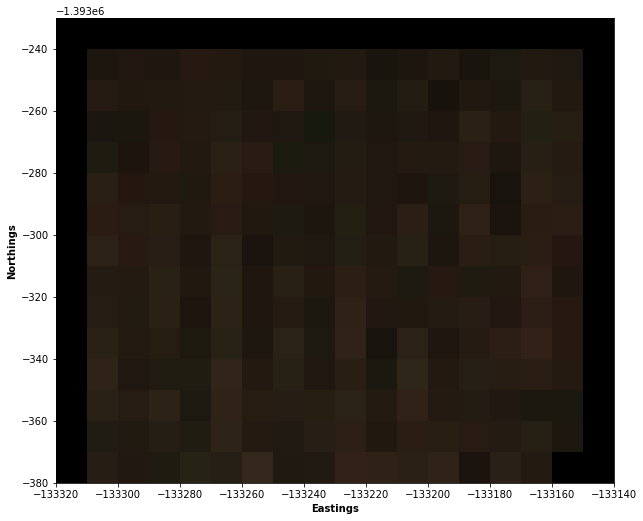

In [30]:
FIG_FieldRGB.FIG_field_RGB(field_array_s2a, output, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [31]:
fls8_df, fs2a_df, fs2b_df = CreateManyStats.create_manystats(ls8_array, s2a_array, s2b_array, ls8_bad_days, s2a_bad_days, s2b_bad_days, ground_brdf_ls8, ground_brdf_s2a, field_data)

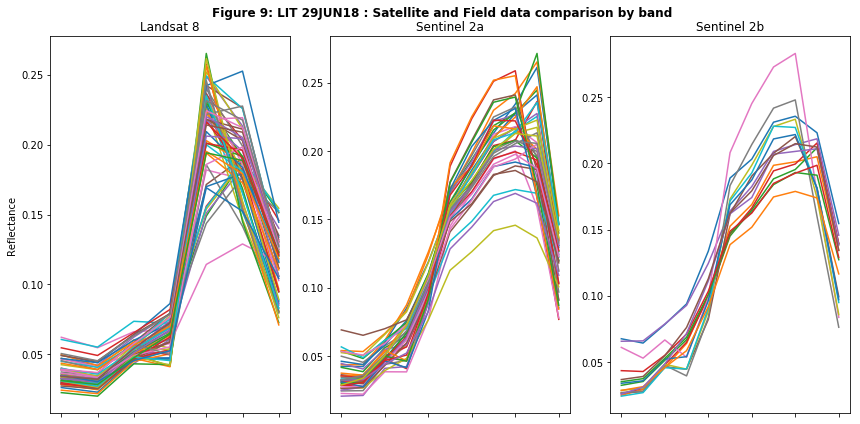

In [32]:
FIG_ManySatFieldBands.FIG_many_sat_field_bands(ls8_array, s2a_array, s2b_array, fls8_df, fs2a_df, fs2b_df, output, field_data, fignum)
fignum += 1

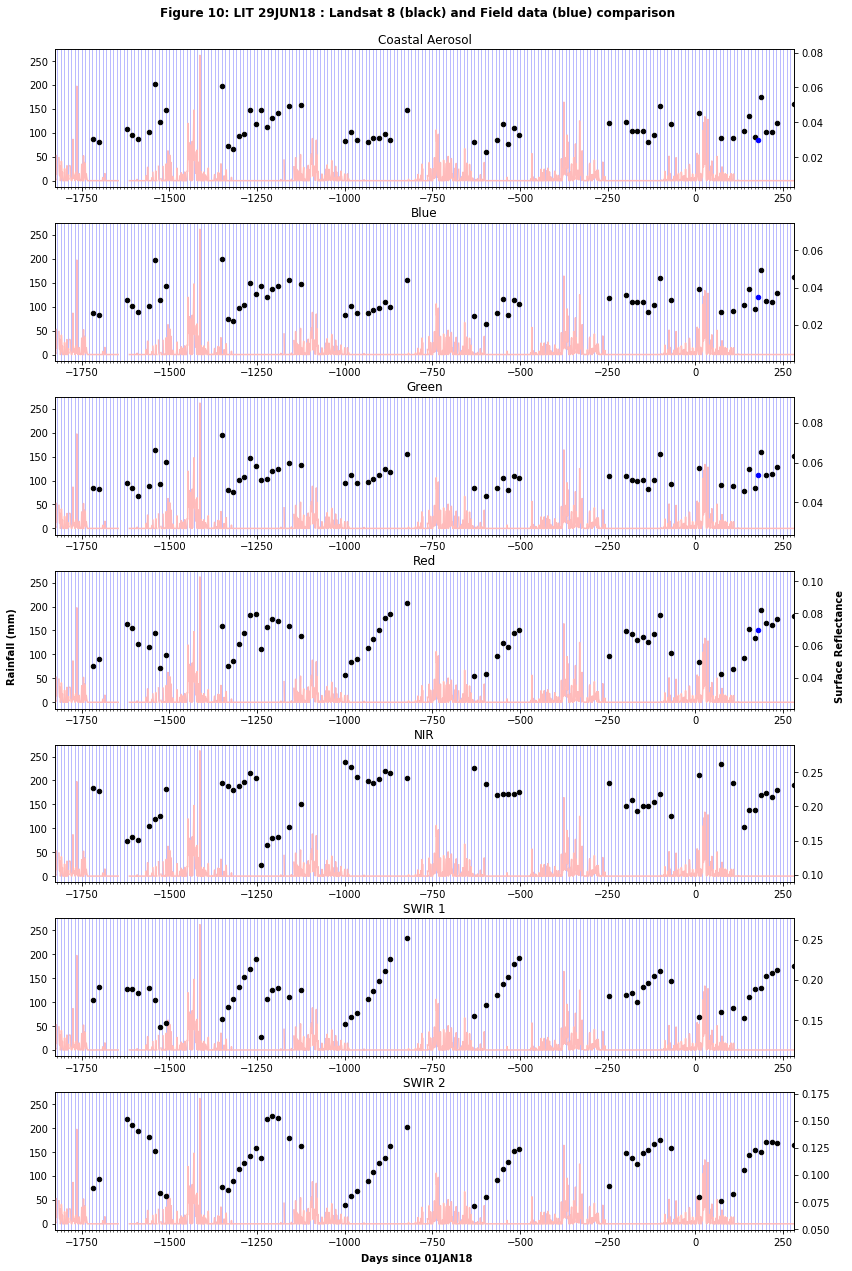

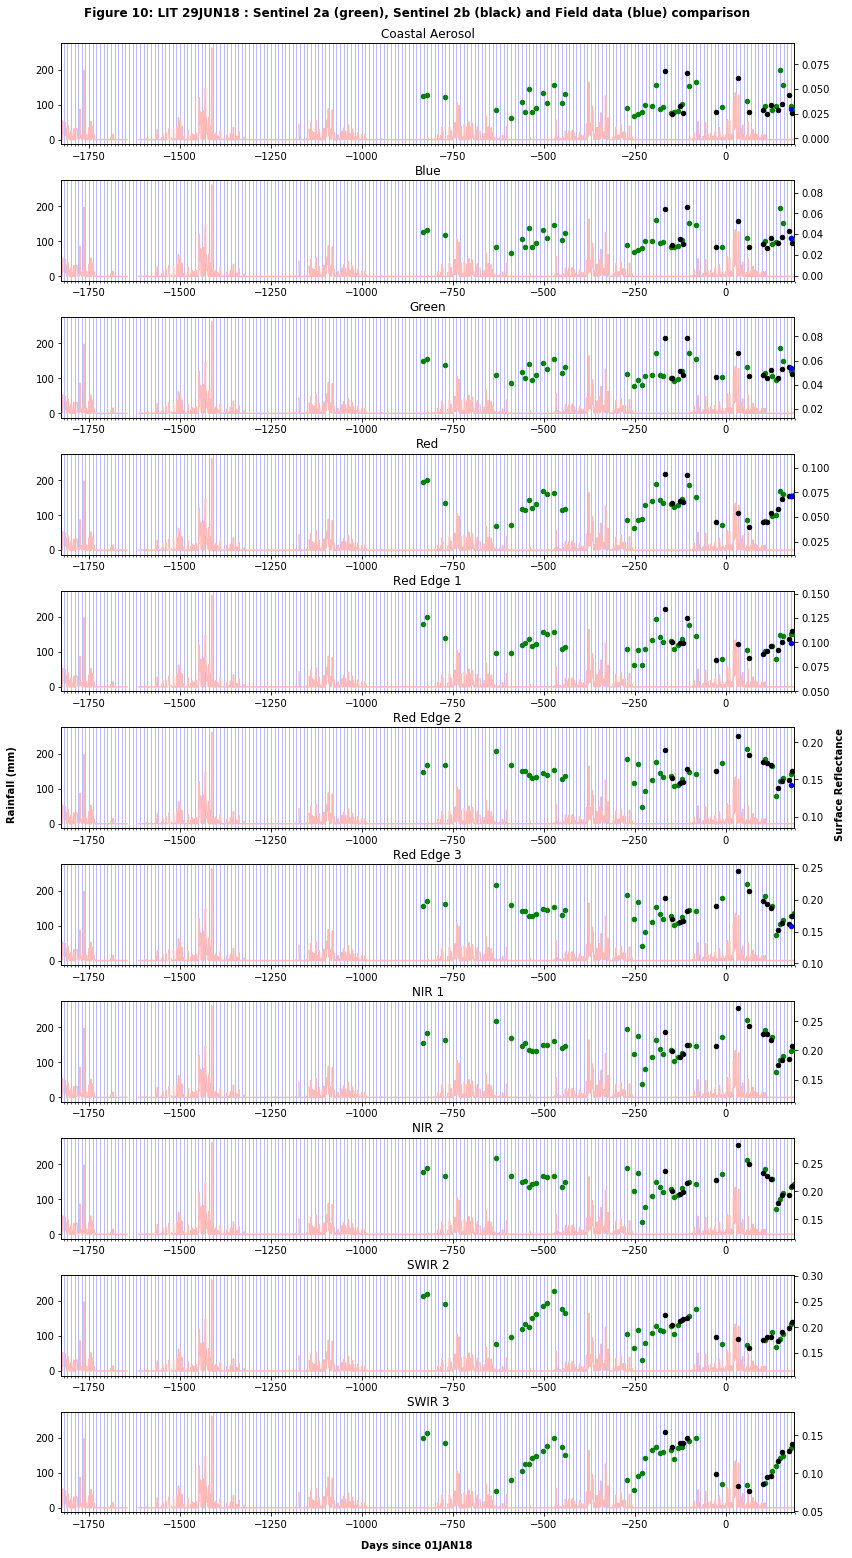

In [33]:
FIG_MultiTimeLine.FIG_multi_time_line(fls8_df, fs2a_df, fs2b_df, ls8_csvs, sent_csvs, rain_dat, field_data, output, fignum)
fignum+=1

In [34]:
dd0_ls8, dd1_ls8, dd0_s2a, dd1_s2a, dd0_s2b, dd1_s2b = CalcStats.calc_stats(fls8_df, fs2a_df, fs2b_df)

LANDSAT 8: Number of adjacent overpasses: 58
Landsat 8 Surface Reflectance for Band 1 is 0.036+/-0.012 (31.72%)
Landsat 8 Surface Reflectance for Band 2 is 0.033+/-0.01 (31.23%)
Landsat 8 Surface Reflectance for Band 3 is 0.053+/-0.009 (16.35%)
Landsat 8 Surface Reflectance for Band 4 is 0.064+/-0.01 (15.14%)
Landsat 8 Surface Reflectance for Band 5 is 0.208+/-0.024 (11.67%)
Landsat 8 Surface Reflectance for Band 6 is 0.184+/-0.021 (11.43%)
Landsat 8 Surface Reflectance for Band 7 is 0.114+/-0.011 (9.44%)

SENTINEL 2a: Number of adjacent overpasses: 39
Sentinel 2a Surface Reflectance for Band 1 is 0.035+/-0.015 (42.19%)
Sentinel 2a Surface Reflectance for Band 2 is 0.035+/-0.013 (36.36%)
Sentinel 2a Surface Reflectance for Band 3 is 0.05+/-0.01 (20.74%)
Sentinel 2a Surface Reflectance for Band 4 is 0.062+/-0.009 (14.41%)
Sentinel 2a Surface Reflectance for Band 5 is 0.099+/-0.012 (11.73%)
Sentinel 2a Surface Reflectance for Band 6 is 0.153+/-0.02 (13.03%)
Sentinel 2a Surface Reflectanc

In [35]:
#MultiTimeLineDry.multi_time_line_dry(fls8_df, fs2a_df, fs2b_df, ls8_csvs, sent_csvs, rain_dat, field_data, output, fignum)

In [36]:
#FIG_MultiTimeLine.FIG_multi_time_line(fls8_df, fs2a_df, fs2b_df, ls8_csvs, sent_csvs, rain_dat, field_data, output, fignum)
#fignum+=1

In [37]:
#dd0_ls8, dd1_ls8, dd0_s2a, dd1_s2a, dd0_s2b, dd1_s2b = CalcStats.calc_stats(fls8_df, fs2a_df, fs2b_df)

In [38]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

This Notebook took  0:21:30 (h:m:s) to run
